# Sprint 10 - Proyecto

## Descripción del proyecto

### Contexto  
Eres analista en una gran tienda online. Junto con el departamento de marketing has recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos.

Tienes que priorizar estas hipótesis, lanzar un test A/B y analizar los resultados.

### Descripción de los datos

**Datos utilizados en la primera parte del proyecto**

`/datasets/hypotheses_us.csv`

- **Hypotheses**: breves descripciones de las hipótesis.  
- **Reach**: alcance del usuario, en una escala del uno a diez.  
- **Impact**: impacto en los usuarios, en una escala del uno a diez.  
- **Confidence**: confianza en la hipótesis, en una escala del uno a diez.  
- **Effort**: los recursos necesarios para probar una hipótesis, en una escala del uno a diez. Cuanto mayor sea el valor Effort, más recursos requiere la prueba.

**Datos utilizados en la segunda parte del proyecto**

`/datasets/orders_us.csv`

- **transactionId**: identificador de pedido.  
- **visitorId**: identificador del usuario que realizó el pedido.  
- **date**: fecha del pedido.  
- **revenue**: ingresos del pedido.  
- **group**: el grupo del test A/B al que pertenece el usuario.

`/datasets/visits_us.csv`

- **date**: la fecha.  
- **group**: grupo de la prueba A/B.  
- **visits**: el número de visitas en la fecha especificada en el grupo de pruebas A/B especificado.


## Paso 1 - Acceda los datos y prepáralos para el análisis 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

In [2]:
#Cargar
hipotesis = pd.read_csv('hypotheses_us.csv',sep = ';')
orders_us = pd.read_csv('orders_us.csv')
visits_us = pd.read_csv('visits_us.csv')

In [3]:
#Explorar
hipotesis.info()
orders_us.info()
visits_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (tota

In [4]:
# convertir la columna 'date' a formato datetime
visits_us['date'] = pd.to_datetime(visits_us['date'])
orders_us['date'] = pd.to_datetime(orders_us['date'])


In [5]:
# Normalizar nombres
hipotesis.columns = hipotesis.columns.str.lower()

In [6]:
# Detectar visitantes en ambos grupos
duplicados = orders_us.groupby('visitorId')['group'].nunique()
usuarios_conflictivos = duplicados[duplicados > 1].index

# Filtrar esos usuarios fuera del DataFrame
orders_us_clean = orders_us[~orders_us['visitorId'].isin(usuarios_conflictivos)]
len(usuarios_conflictivos)

58

Eliminamos 58 usuarios que aparecían en ambos grupos, A y B, ya que su presencia en ambos invalida la prueba A/B. 


## Paso 2 - Priorización de hipótesis (ICE y RICE)

In [7]:
hipotesis.head(9)

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [8]:
# Calculamos ICE
hipotesis['ICE'] = (hipotesis['impact'] * hipotesis['confidence']) / hipotesis['effort']

# Calculamos RICE
hipotesis['RICE'] = (hipotesis['reach'] * hipotesis['impact'] * hipotesis['confidence']) / hipotesis['effort']

In [9]:
hipotesis

,hypothesis,reach,impact,confidence,effort,ICE,RICE
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2


In [10]:
# Ordenar por ICE
hipotesis_ice = hipotesis.sort_values(by='ICE', ascending=False)

# Ordenar por RICE
hipotesis_rice = hipotesis.sort_values(by='RICE', ascending=False)

In [11]:
hipotesis_ice

,hypothesis,reach,impact,confidence,effort,ICE,RICE
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


In [12]:
hipotesis_rice

,hypothesis,reach,impact,confidence,effort,ICE,RICE
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


Observamos un cambio notable en el orden de prioridad. Esto se debe a que **RICE** incluye el factor **Reach (alcance)**, lo que permite valorar mejor el impacto potencial total de cada hipótesis sobre la base de usuarios. Por ejemplo, la hipótesis *"Add a subscription form to all the main pages."* sube al primer lugar en RICE debido a su alto alcance, mientras que *"Launch a promotion that gives users discounts on their first purchase."* —aunque tiene un ICE alto— cae en la lista por afectar a pocos usuarios.


## Paso 3 - Análisis del test A/B

### Representa gráficamente el ingreso acumulado por grupo. Haz conclusiones y conjeturas.

In [13]:
# Agrupar ingresos por fecha y grupo
revenue_daily = orders_us_clean.groupby(['date', 'group'])['revenue'].sum().reset_index()
revenue_daily

,date,group,revenue
0,2019-08-01,A,2266.6
1,2019-08-01,B,967.2
2,2019-08-02,A,1468.3
3,2019-08-02,B,2568.1
4,2019-08-03,A,1815.2
...,...,...,...
57,2019-08-29,B,1681.2
58,2019-08-30,A,1228.9
59,2019-08-30,B,3286.8
60,2019-08-31,A,848.3


In [14]:
# Calcular ingresos acumulados
revenue_daily['cumulative_revenue'] = revenue_daily.groupby('group')['revenue'].cumsum()
revenue_daily

,date,group,revenue,cumulative_revenue
0,2019-08-01,A,2266.6,2266.6
1,2019-08-01,B,967.2,967.2
2,2019-08-02,A,1468.3,3734.9
3,2019-08-02,B,2568.1,3535.3
4,2019-08-03,A,1815.2,5550.1
...,...,...,...,...
57,2019-08-29,B,1681.2,74576.7
58,2019-08-30,A,1228.9,52363.7
59,2019-08-30,B,3286.8,77863.5
60,2019-08-31,A,848.3,53212.0


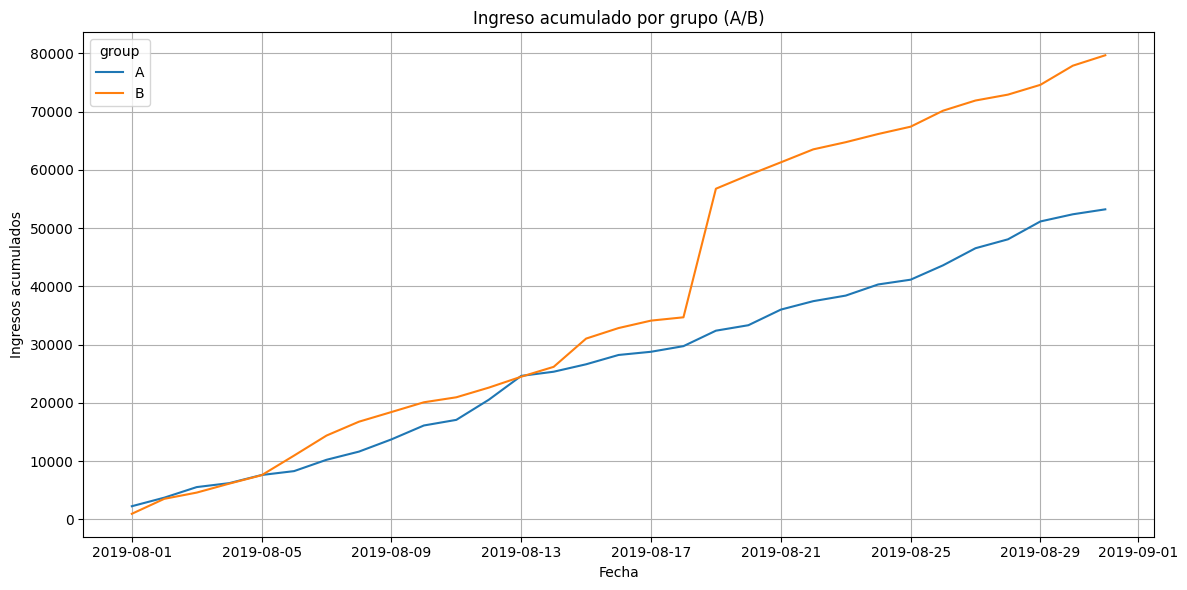

In [15]:
plt.figure(figsize=(12,6))
sns.lineplot(data=revenue_daily, x='date', y='cumulative_revenue', hue='group')
plt.title('Ingreso acumulado por grupo (A/B)')
plt.xlabel('Fecha')
plt.ylabel('Ingresos acumulados')
plt.grid(True)
plt.tight_layout()
plt.show()

Observamos que ambos grupos muestran un crecimiento constante en el tiempo. Sin embargo, el grupo B parece tener un ingreso acumulado ligeramente mayor en las etapas finales del experimento. Esto podría indicar que las modificaciones aplicadas al grupo B están generando un impacto positivo en la conversión o el ticket promedio. Aun así, no es suficiente para sacar una conclusión definitiva sin realizar pruebas estadísticas, ya que las diferencias pueden deberse al azar o a la presencia de valores atípicos.

### Tamaño de pedido promedio acumulado por grupo

In [16]:
# Agrupar ingresos y número de pedidos diarios por grupo
daily_orders = orders_us_clean.groupby(['date', 'group']).agg({
    'revenue': 'sum',
    'transactionId': 'count'
}).reset_index()

daily_orders = daily_orders.rename(columns={'transactionId': 'orders'})

daily_orders

,date,group,revenue,orders
0,2019-08-01,A,2266.6,23
1,2019-08-01,B,967.2,17
2,2019-08-02,A,1468.3,19
3,2019-08-02,B,2568.1,23
4,2019-08-03,A,1815.2,24
...,...,...,...,...
57,2019-08-29,B,1681.2,15
58,2019-08-30,A,1228.9,9
59,2019-08-30,B,3286.8,21
60,2019-08-31,A,848.3,8


In [17]:
# Cálculos acumulados
daily_orders['cumulative_revenue'] = daily_orders.groupby('group')['revenue'].cumsum()
daily_orders['cumulative_orders'] = daily_orders.groupby('group')['orders'].cumsum()
daily_orders

,date,group,revenue,orders,cumulative_revenue,cumulative_orders
0,2019-08-01,A,2266.6,23,2266.6,23
1,2019-08-01,B,967.2,17,967.2,17
2,2019-08-02,A,1468.3,19,3734.9,42
3,2019-08-02,B,2568.1,23,3535.3,40
4,2019-08-03,A,1815.2,24,5550.1,66
...,...,...,...,...,...,...
57,2019-08-29,B,1681.2,15,74576.7,510
58,2019-08-30,A,1228.9,9,52363.7,460
59,2019-08-30,B,3286.8,21,77863.5,531
60,2019-08-31,A,848.3,8,53212.0,468


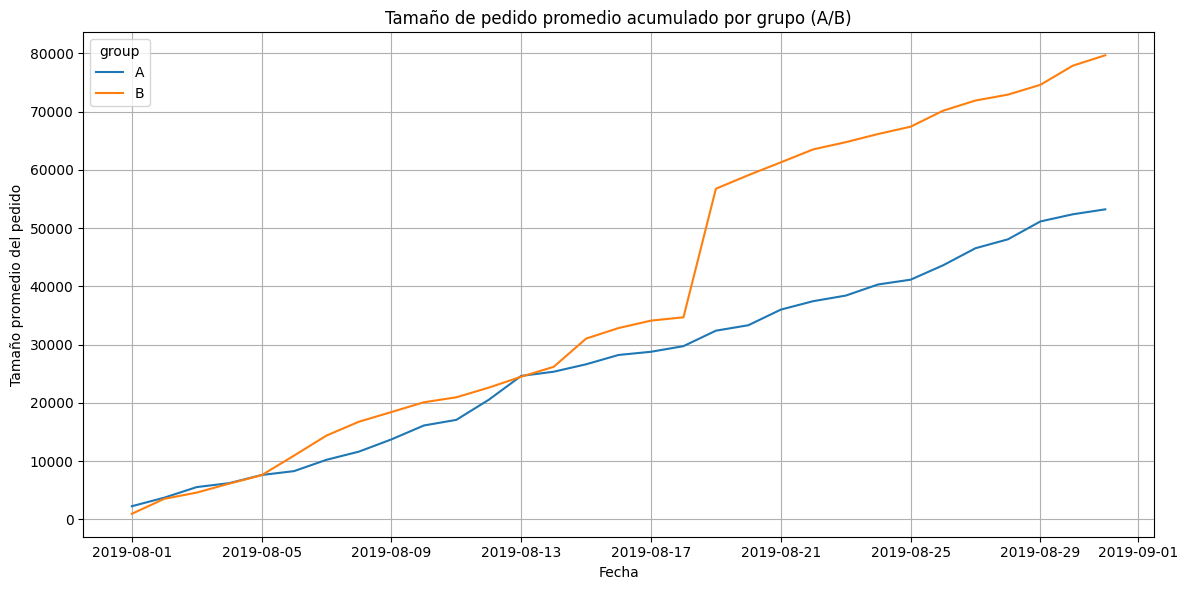

In [18]:
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_orders, x='date', y='cumulative_revenue', hue='group')
plt.title('Tamaño de pedido promedio acumulado por grupo (A/B)')
plt.xlabel('Fecha')
plt.ylabel('Tamaño promedio del pedido')
plt.grid(True)
plt.tight_layout()
plt.show()

Observamos diferencias entre los grupos a lo largo del tiempo. En particular, el grupo B presenta un pico muy marcado el día **2019-08-19**, lo cual sugiere que ese día se registró uno o varios pedidos anormalmente grandes. Este tipo de evento puede elevar artificialmente el promedio. Este comportamiento refuerza la necesidad de analizar los valores atípicos antes de llegar a conclusiones definitivas, ya que podrían estar influyendo de manera desproporcionada en las métricas acumuladas.

### Diferencia relativa en el tamaño de pedido promedio acumulado (Grupo B vs. Grupo A)

In [19]:
# Calcular tamaño promedio de pedido acumulado
daily_orders['cumulative_avg_order_value'] = (
    daily_orders['cumulative_revenue'] / daily_orders['cumulative_orders']
)
daily_orders

,date,group,revenue,orders,cumulative_revenue,cumulative_orders,cumulative_avg_order_value
0,2019-08-01,A,2266.6,23,2266.6,23,98.547826
1,2019-08-01,B,967.2,17,967.2,17,56.894118
2,2019-08-02,A,1468.3,19,3734.9,42,88.926190
3,2019-08-02,B,2568.1,23,3535.3,40,88.382500
4,2019-08-03,A,1815.2,24,5550.1,66,84.092424
...,...,...,...,...,...,...,...
57,2019-08-29,B,1681.2,15,74576.7,510,146.228824
58,2019-08-30,A,1228.9,9,52363.7,460,113.834130
59,2019-08-30,B,3286.8,21,77863.5,531,146.635593
60,2019-08-31,A,848.3,8,53212.0,468,113.700855


In [20]:
# Separar A y B
groupA = daily_orders[daily_orders['group'] == 'A'][['date', 'cumulative_avg_order_value']].rename(
    columns={'cumulative_avg_order_value': 'avg_A'}
)
groupB = daily_orders[daily_orders['group'] == 'B'][['date', 'cumulative_avg_order_value']].rename(
    columns={'cumulative_avg_order_value': 'avg_B'}
)
# Unir por fecha
merged = groupA.merge(groupB, on='date')
merged.head()

,date,avg_A,avg_B
0,2019-08-01,98.547826,56.894118
1,2019-08-02,88.926190,88.382500
2,2019-08-03,84.092424,85.312963
3,2019-08-04,80.851948,90.272059
4,2019-08-05,77.006061,85.256180


In [21]:
# Calcular diferencia relativa
merged['relative_diff'] = (merged['avg_B'] - merged['avg_A']) / merged['avg_A']
merged.head()

,date,avg_A,avg_B,relative_diff
0,2019-08-01,98.547826,56.894118,-0.422675
1,2019-08-02,88.926190,88.382500,-0.006114
2,2019-08-03,84.092424,85.312963,0.014514
3,2019-08-04,80.851948,90.272059,0.116511
4,2019-08-05,77.006061,85.256180,0.107136


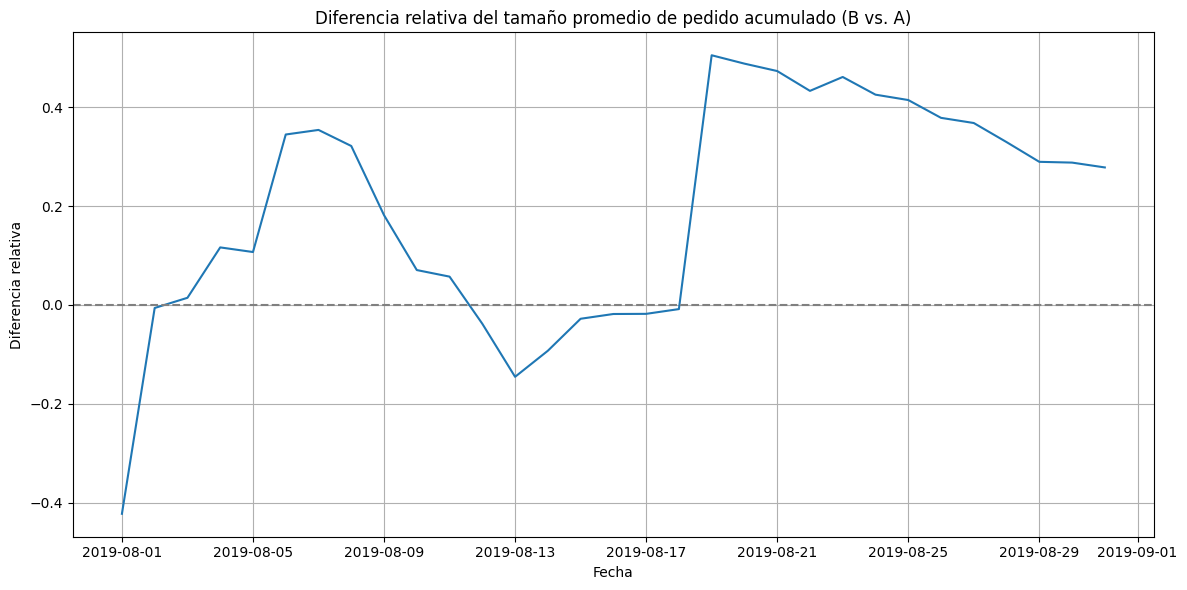

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(data=merged, x='date', y='relative_diff')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Diferencia relativa del tamaño promedio de pedido acumulado (B vs. A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.grid(True)
plt.tight_layout()
plt.show()

La gráfica muestra claramente que el grupo B, la mayor parte del tiempo, tiene un tamaño de pedido promedio acumulado mayor que el grupo A, ya que la línea se mantiene por encima de cero. Destaca especialmente el día 2019-08-19, donde se observa un pico que indica una subida pronunciada en el grupo B, probablemente causada por uno o más pedidos inusualmente altos.

### Tasa de conversión 

In [23]:
# Calcular pedidos diarios por fecha y grupo
orders_per_day = orders_us_clean.groupby(['date', 'group'])['transactionId'].count().reset_index()
orders_per_day = orders_per_day.rename(columns={'transactionId': 'orders'})
orders_per_day

,date,group,orders
0,2019-08-01,A,23
1,2019-08-01,B,17
2,2019-08-02,A,19
3,2019-08-02,B,23
4,2019-08-03,A,24
...,...,...,...
57,2019-08-29,B,15
58,2019-08-30,A,9
59,2019-08-30,B,21
60,2019-08-31,A,8


In [24]:
# Unir con visitas
conversion = visits_us.merge(orders_per_day, on=['date', 'group'])
conversion['orders'] = conversion['orders'].fillna(0)
conversion

,date,group,visits,orders
0,2019-08-01,A,719,23
1,2019-08-02,A,619,19
2,2019-08-03,A,507,24
3,2019-08-04,A,717,11
4,2019-08-05,A,756,22
...,...,...,...,...
57,2019-08-27,B,720,11
58,2019-08-28,B,654,22
59,2019-08-29,B,531,15
60,2019-08-30,B,490,21


In [25]:
# Calcular tasa de conversión
conversion['conversion_rate'] = conversion['orders'] / conversion['visits']
conversion

,date,group,visits,orders,conversion_rate
0,2019-08-01,A,719,23,0.031989
1,2019-08-02,A,619,19,0.030695
2,2019-08-03,A,507,24,0.047337
3,2019-08-04,A,717,11,0.015342
4,2019-08-05,A,756,22,0.029101
...,...,...,...,...,...
57,2019-08-27,B,720,11,0.015278
58,2019-08-28,B,654,22,0.033639
59,2019-08-29,B,531,15,0.028249
60,2019-08-30,B,490,21,0.042857


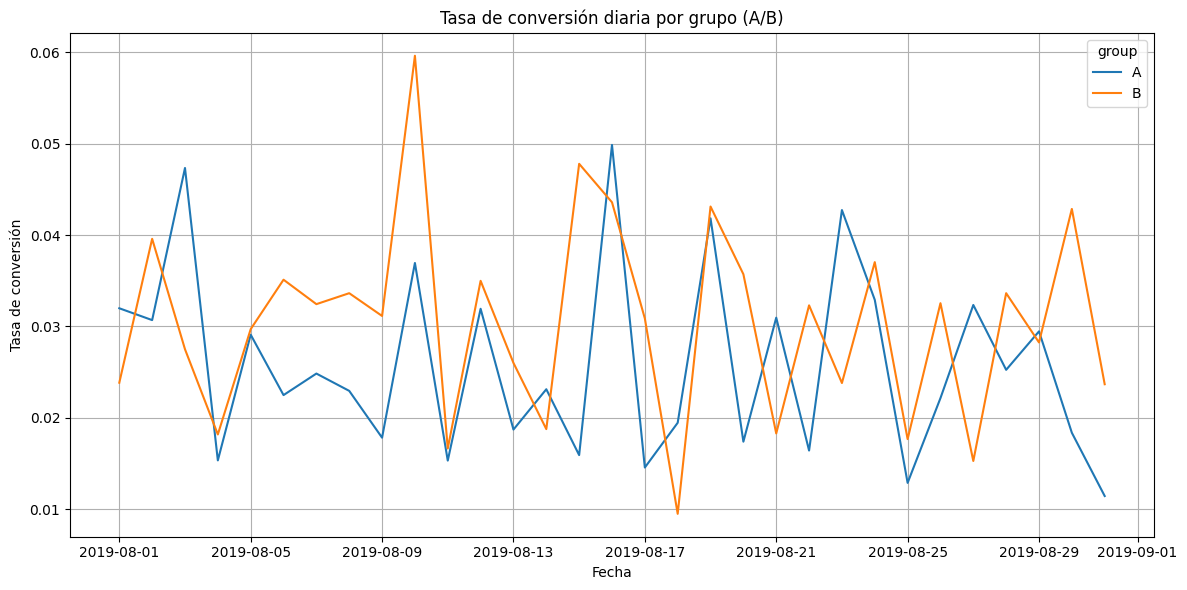

In [26]:
plt.figure(figsize=(12,6))
sns.lineplot(data=conversion, x='date', y='conversion_rate', hue='group')
plt.title('Tasa de conversión diaria por grupo (A/B)')
plt.xlabel('Fecha')
plt.ylabel('Tasa de conversión')
plt.grid(True)
plt.tight_layout()
plt.show()

El 19 de agosto, el grupo B presenta una caída en la tasa de conversión, lo que indica que hubo muchas visitas pero pocos pedidos. Sin embargo, el tamaño promedio de los pedidos se disparó, lo que sugiere que uno o más usuarios hicieron compras inusualmente grandes. Este contraste refleja cómo una sola acción atípica puede impactar significativamente una métrica sin necesariamente mejorar otras. Es por eso que siempre es importante analizar múltiples métricas juntas, no de forma aislada.

### Gráfico de dispersión del número de pedidos por usuario 

In [27]:
# Contar número de pedidos por usuario
orders_per_user = orders_us_clean.groupby('visitorId')['transactionId'].count().reset_index()
orders_per_user = orders_per_user.rename(columns={'transactionId': 'orders'})
orders_per_user

,visitorId,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1
...,...,...
968,4259830713,1
969,4278982564,1
970,4279090005,1
971,4281247801,1


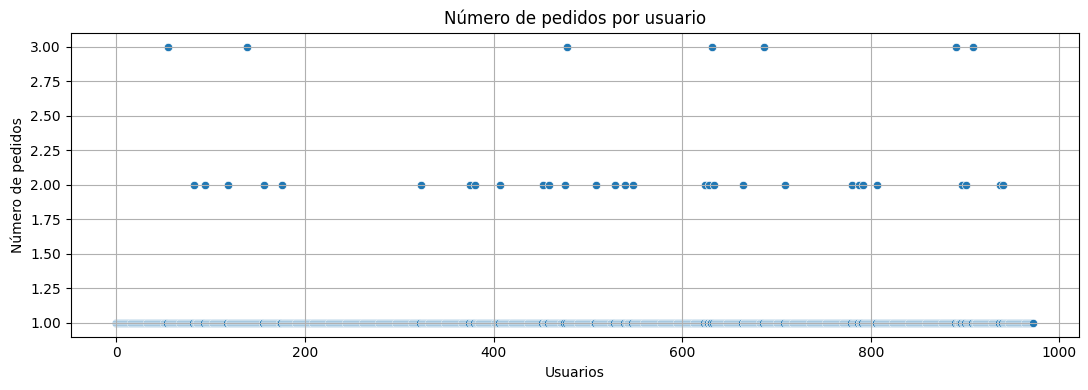

In [28]:
plt.figure(figsize=(11,4))
sns.scatterplot(x=range(len(orders_per_user)), y='orders', data=orders_per_user)
plt.title('Número de pedidos por usuario')
plt.xlabel('Usuarios')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.tight_layout()
plt.show()

La mayoría de los usuarios realizaron solo un pedido durante el periodo del experimento, lo cual es común en tiendas online. Un número mucho menor de usuarios hizo dos o tres pedidos, y solo unos pocos superaron esa cantidad.

### Calcular los percentiles 95 y 99

In [29]:
# Calcular percentiles
p95 = orders_per_user['orders'].quantile(0.95)
p99 = orders_per_user['orders'].quantile(0.99)

print(f"Percentil 95: {p95}")
print(f"Percentil 99: {p99}")

Percentil 95: 1.0
Percentil 99: 2.0


El análisis muestra que el 95% de los usuarios hizo solo un pedido, y el 99% hizo como máximo dos pedidos. Esto significa que hacer más de dos pedidos es extremadamente raro dentro del periodo analizado. Por lo tanto, los usuarios con tres o más pedidos pueden considerarse outliers o comportamientos inusuales que podrían distorsionar los resultados si no se tratan adecuadamente.

### Gráfico de dispersión de los precios de los pedido

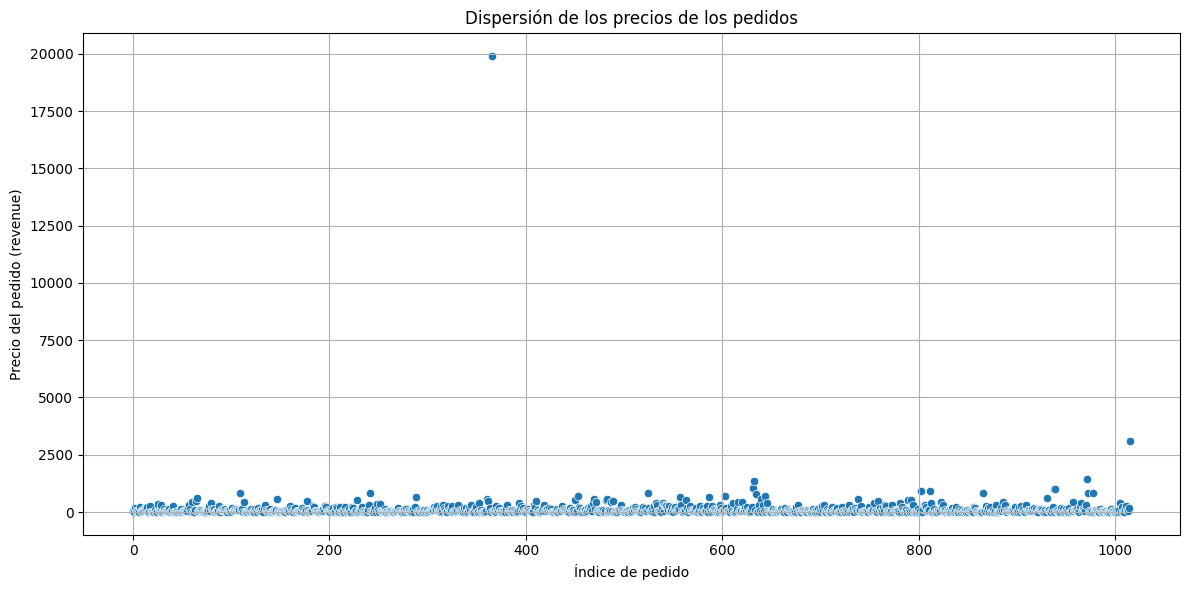

In [30]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=range(len(orders_us_clean)), y='revenue', data=orders_us_clean)
plt.title('Dispersión de los precios de los pedidos')
plt.xlabel('Índice de pedido')
plt.ylabel('Precio del pedido (revenue)')
plt.grid(True)
plt.tight_layout()
plt.show()

La mayoría de los pedidos tienen precios bajos y están concentrados cerca del eje cero. Sin embargo, se observan algunos pedidos con precios mucho más altos que el resto, destacando especialmente uno alrededor del índice 400 con un valor cercano a los 20,000 y otro alrededor del índice 1000 que supera los 2,500. Estos pedidos se comportan como outliers

### Calcular los percentiles 95 y 99 de los precios de los pedidos

In [31]:
# Calcular percentiles
p95_revenue = orders_us_clean['revenue'].quantile(0.95)
p99_revenue = orders_us_clean['revenue'].quantile(0.99)

print(f"Percentil 95: {p95_revenue}")
print(f"Percentil 99: {p99_revenue}")

Percentil 95: 414.275
Percentil 99: 830.3


El análisis muestra que el 95% de los pedidos tienen un precio igual o menor a $414.28, y el 99% están por debajo de $830.30. Esto significa que cualquier pedido con un precio superior a $830 puede considerarse un outlier, ya que se encuentra fuera del comportamiento habitual del 99% de los datos.

### Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto.

In [32]:
# Total de visitas por grupo
visits_total = visits_us.groupby('group')['visits'].sum()

# Total de pedidos por grupo
orders_total = orders_us_clean.groupby('group')['transactionId'].count()

# Preparar datos
counts = np.array([orders_total['A'], orders_total['B']])
nobs = np.array([visits_total['A'], visits_total['B']])

# Ejecutar prueba Z
z_stat, p_val = proportions_ztest(count=counts, nobs=nobs, alternative='two-sided')

print(f"Estadístico Z: {z_stat:.4f}")
print(f"Valor p: {p_val:.4f}")

Estadístico Z: -2.3899
Valor p: 0.0169


La prueba de hipótesis sobre la tasa de conversión entre los grupos A y B arroja un valor p de 0.0169, lo cual es menor al umbral de significancia de 0.05. Esto indica que la diferencia entre los grupos es estadísticamente significativa y no se debe al azar. Dado que el estadístico Z es negativo, podemos conjeturar que el grupo B tuvo una tasa de conversión más baja que el grupo A en los datos sin filtrar.

### Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto. 

In [33]:
# Crear dos series con los precios de los pedidos por grupo
group_a_revenue = orders_us_clean[orders_us_clean['group'] == 'A']['revenue']
group_b_revenue = orders_us_clean[orders_us_clean['group'] == 'B']['revenue']

# Prueba t de Student (asumiendo varianzas diferentes)
t_stat, p_val = ttest_ind(group_a_revenue, group_b_revenue, equal_var=False)

print(f"Estadístico t: {t_stat:.4f}")
print(f"Valor p: {p_val:.4f}")

Estadístico t: -0.8345
Valor p: 0.4043


Al comparar el tamaño promedio de pedido entre los grupos A y B usando los datos sin filtrar, obtuvimos un valor p de 0.4043. Esto significa que no existe una diferencia estadísticamente significativa entre los promedios de ambos grupos.

### Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.


In [34]:
outlier_users = orders_per_user[orders_per_user['orders'] > 2]['visitorId']
outlier_users

55      249864742
138     611059232
478    2108163459
632    2742574263
687    2988190573
890    3908431265
908    3967698036
Name: visitorId, dtype: int64

In [35]:
# Pedidos con revenue > 830.3
outlier_orders = orders_us_clean[orders_us_clean['revenue'] > 830.3]['transactionId']
outlier_orders


425      590470918
743     3603576309
744     3668308183
940     2420050534
949     1347999392
1099     316924019
1103    1348774318
1136     666610489
1196    3936777065
Name: transactionId, dtype: int64

In [36]:
# Eliminar outliers del DataFrame de órdenes
orders_filtered = orders_us_clean[
    (~orders_us_clean['visitorId'].isin(outlier_users)) & 
    (~orders_us_clean['transactionId'].isin(outlier_orders))
]

In [37]:
# Recalcular pedidos por grupo con datos filtrados
filtered_orders_total = orders_filtered.groupby('group')['transactionId'].count()

In [38]:
# Prueba Z
counts = np.array([filtered_orders_total['A'], filtered_orders_total['B']])
nobs = np.array([visits_total['A'], visits_total['B']])

z_stat, p_val = proportions_ztest(count=counts, nobs=nobs, alternative='two-sided')

print(f"Estadístico Z: {z_stat:.4f}")
print(f"Valor p: {p_val:.4f}")

Estadístico Z: -2.7524
Valor p: 0.0059


Tras eliminar los outliers (usuarios con más de 2 pedidos y pedidos con un valor superior a $830.3), volvimos a realizar la prueba de significancia para la tasa de conversión. El valor p obtenido fue 0.0059, lo que indica que la diferencia entre los grupos A y B es estadísticamente significativa. Además, el estadístico Z negativo confirma que el grupo B tiene una tasa de conversión menor que el grupo A.

### Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados

In [39]:
# Valores de revenue por grupo (datos filtrados)
group_a_revenue_filtered = orders_filtered[orders_filtered['group'] == 'A']['revenue']
group_b_revenue_filtered = orders_filtered[orders_filtered['group'] == 'B']['revenue']

In [40]:
# Prueba t de Student
t_stat, p_val = ttest_ind(group_a_revenue_filtered, group_b_revenue_filtered, equal_var=False)

print(f"Estadístico t: {t_stat:.4f}")
print(f"Valor p: {p_val:.4f}")

Estadístico t: 0.3807
Valor p: 0.7035


Luego de filtrar los outliers, realizamos una prueba de hipótesis para comparar el tamaño promedio de pedido entre los grupos A y B. El valor p fue de 0.7035, muy por encima del umbral de significancia (0.05). Esto indica que no hay diferencia estadísticamente significativa entre los promedios de ambos grupos. Aunque el grupo B muestra un promedio ligeramente más alto, esta diferencia puede deberse al azar. Por lo tanto, no podemos afirmar que la modificación haya influido en el tamaño promedio de los pedidos.

### Toma una decisión basada en los resultados de la prueba

**No hay diferencia entre los grupos** en después de filtrar los datos. Esto se concluye a partir del valor p de 0.7035 obtenido en la prueba t de Student, el cual es muy superior al umbral de significancia de 0.05. Este resultado indica que la ligera diferencia observada entre los promedios de los grupos A y B puede explicarse por el azar y no por un efecto real de la modificación aplicada. Por lo tanto, no se puede afirmar que el cambio implementado en el grupo B haya influido significativamente en el monto promedio de los pedidos.**